# End-To-End Training Example of RNN for rain estimation and detection using PyNNCML
This notebook presents an end-to-end example of training a Recurrent Neural Network (RNN) based rain estimation neural network [1] on the openMRG dataset.
This tutorial is built using the PyNNCML software package, which provides both tools to simplify the training process of deep learning models for CMLs.
We start with obtaining a subset of the OpenMRG dataset and splitting it into training and validation datasets.
Afterward, we construct the One Step Network from [1], followed by the training loop.
Finally, we analyze the model performance in terms of RMSE and Bias.


Notebook structure
1. Imports and Installation of PyNNCML
2. Hyperparameter settings
3. Build Dataset
4. Build Neural Network
5. Training Loop
6. Neural Network Analysis


[Run this notebook in colab](https://colab.research.google.com/github/haihabi/PyNNcml/blob/master/examples/training_rnn.ipynb)

To run this notebook on Colab using GPU, please do the following:
Runtime -> Change runtime type -> Select GPU -> Save


In [23]:
import sys
import os

if os.path.exists('../pynncml'):
    print("Import PyNNCML From Code")
    sys.path.append('../')  # This line is need to import pynncml
else:
    print("Install PyNNCML From pip")
    !pip install pynncml

import numpy as np
import pynncml as pnc
import torch
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy

Import PyNNCML From Code


In [3]:
batch_size = 16
window_size = 32
lr = 1e-4
rnn_type = pnc.neural_networks.RNNType.GRU
n_layers = 2
n_epochs = 200
xy_min = [1.29e6, 0.565e6]  # Link Region
xy_max = [1.34e6, 0.5875e6]
time_slice = slice("2015-06-01", "2015-06-10")  # Time Interval
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Building Training and Validation datasets

File already exists at desired location ./data/OpenMRG.zip
Not downloading!


100%|██████████| 728/728 [00:10<00:00, 69.37it/s] 


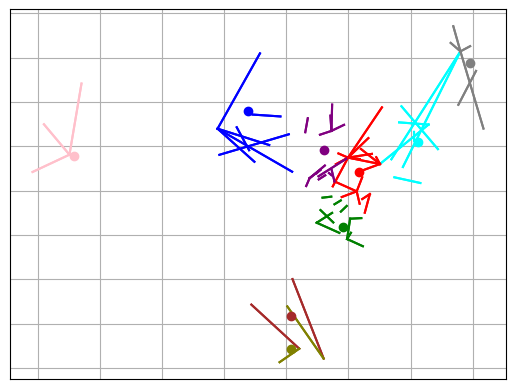

In [5]:
dataset = pnc.datasets.loader_open_mrg_dataset(xy_min=xy_min, xy_max=xy_max, time_slice=time_slice)
dataset.link_set.plot_links()
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
data_loader = torch.utils.data.DataLoader(training_dataset, batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size)


# Compute rain rate statistics
In this section, we compute the rain rate statistics of the dataset. The rain rate statistics are used to understand the distribution of the rain rate in the dataset.
In addition we estimate the parameters of the exponential distribution that fits the rain rate data that will be utilized in later stage to compute a balance loss function.


Rain Rate Statistics
Mean[mm/hr]: 0.12803642582835348
Std[mm/hr]: 0.6123836062324627
Parentage of wet samples 10.171653908605892
Parentage of dry samples 89.82834609139411
Exponential Distribution Parameters: (0.0, 0.12803642582835348)


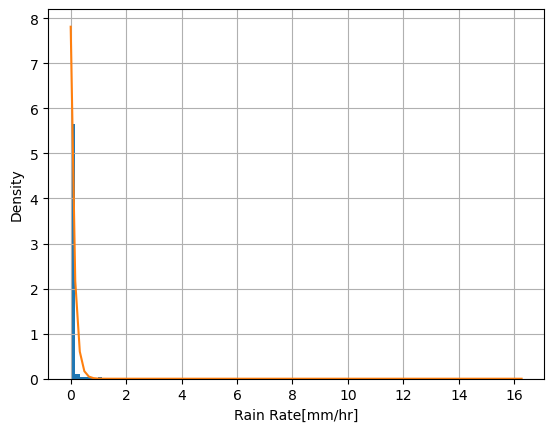

In [35]:
rg = np.stack([p.data_array for p in dataset.point_set]).flatten()
param = scipy.stats.expon.fit(rg)
print("Rain Rate Statistics")
print("Mean[mm/hr]:", np.mean(rg))
print("Std[mm/hr]:", np.std(rg))
print("Parentage of wet samples", 100 * np.sum(rg > 0) / rg.size)
print("Parentage of dry samples", 100 * np.sum(rg == 0) / rg.size)
print("Exponential Distribution Parameters:", param)
_ = plt.hist(rg, bins=100, density=True)
plt.plot(np.linspace(0, np.max(rg), 100), scipy.stats.expon.pdf(np.linspace(0, np.max(rg), 100), *param))
plt.grid()
plt.xlabel("Rain Rate[mm/hr]")
plt.ylabel("Density")
plt.show()


# Neural Network

The neural network is constructed using the PyTorch library. The network consists of two main components:
1. RNN: A recurrent neural network that takes the radar signal and the metadata as input and outputs the rain rate.
2. Metadata: A fully connected layer that takes the metadata as input and outputs a feature vector.
The RNN is trained to predict the rain rate at each time step based on the radar signal and the metadata.
3. The network architecture is shown in the figure below:
![Alt text](two_step_network.png "a title")


The network consists of the following components:
1. A backbone that is build of RNN layers that process the CML attenuation and the metadata (shown in blue).
2. A wet/dry classifier that is build of fully connected layers that process backbone feature and produce wet/dry prediction (shown in red).
3. A rain rate estimator that is build of fully connected layers that process backbone feature and produce rain rate prediction (shown in green).






In [52]:
model = pnc.scm.rain_estimation.two_step_network(n_layers=n_layers,  # Number of RNN layers
                                                 rnn_type=rnn_type,  # Type of RNN (GRU, LSTM)
                                                 normalization_cfg=pnc.training_helpers.compute_data_normalization(
                                                     data_loader),
                                                 # Compute the normalization statistics from the training dataset.
                                                 rnn_input_size=180,  # 90 + 90 (RSL + TSL)
                                                 rnn_n_features=128,  # Number of features in the RNN
                                                 metadata_input_size=2,  # Number of metadata features
                                                 metadata_n_features=32,  # Number of features in the metadata
                                                 pretrained=False).to(
    device)  # Pretrained model is set to False to train the model from scratch.

# Training Loop

The training loop consists of the following steps:
1. Initialize the optimizer and loss function:
    a. Optimizer: We use the RAdam optimizer with a learning rate of 1e-4 and a weight decay of 1e-4.
    b. Loss Function: We use the Mean Squared Error (MSE) loss function to compute the loss.
2. Iterate over the training dataset and compute the loss.
3. Update the model parameters using the optimizer.
4. Compute the average loss over the training dataset.
5. Repeat the process for a fixed number of epochs.

In [53]:
opt = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=1e-4)
loss_function_rain_est = torch.nn.MSELoss()
loss_function_wet_dry = torch.nn.BCELoss()
ra = pnc.analysis.ResultsAccumulator()
am = pnc.analysis.AverageMetric()
model.train()
print("Start Training")
for epoch in tqdm(range(n_epochs)):
    am.clear()
    for rain_rate, rsl, tsl, metadata in data_loader:
        state = model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        for step in range(m_step):
            opt.zero_grad()
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                     state.detach())
            rain_hat = rain_estimation_detection[:, :, 0]
            rain_detection = rain_estimation_detection[:, :, 1]

            loss_est = loss_function_rain_est(rain_hat, _rr)
            loss_detection = loss_function_wet_dry(rain_detection, (_rr > 0.1).float())
            loss = loss_est + loss_detection
            loss.backward()
            am.add_results(loss=loss.item(), loss_est=loss_est.item(), loss_detection=loss_detection.item())
            opt.step()
    ra.add_results(loss=am.get_results("loss"), loss_est=am.get_results("loss_est"),loss_detection=am.get_results("loss_detection"))

Start Training


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


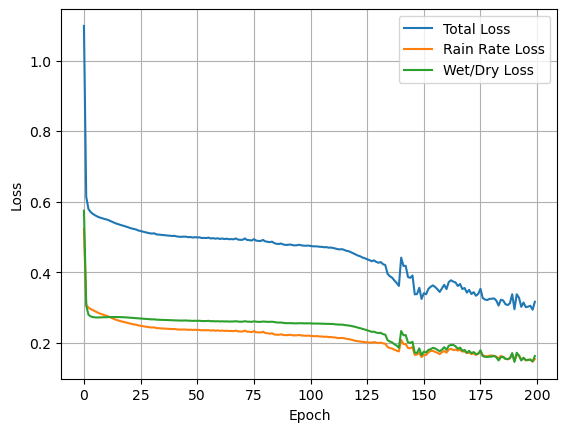

In [54]:
plt.plot(ra.get_results("loss"), label="Total Loss")
plt.plot(ra.get_results("loss_est"), label="Rain Rate Loss")
plt.plot(ra.get_results("loss_detection"), label="Wet/Dry Loss")
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Model Validation

In [55]:
model.eval()
for rain_rate, rsl, tsl, metadata in val_loader:
    state = model.init_state(batch_size=rsl.shape[0])
    m_step = math.floor(rain_rate.shape[1] / window_size)
    am.clear()
    rain_hat_list = []
    rain_ref_list = []
    for step in range(m_step):
        _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
        _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
        _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
        rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device), state.detach())
        rain_detection = rain_estimation_detection[:, :, 1]
        rain_hat = rain_estimation_detection[:, :, 0]*torch.round(rain_detection) # Rain Rate is computed only for wet samples

        rain_hat_list.append(rain_hat.detach().cpu().numpy())
        rain_ref_list.append(_rr.detach().cpu().numpy())
        delta = rain_hat.squeeze(dim=-1) - _rr
        bias = torch.mean(delta)
        mse = torch.mean(delta ** 2)
        am.add_results(bias=bias.item(), mse=mse.item())
print("Validation Results of One-Step RNN")
print("Bias[mm/hr]:", am.get_results("bias"))
print("RMSE[mm/hr]:", np.sqrt(am.get_results("mse")))

Validation Results of One-Step RNN
Bias[mm/hr]: -0.03205092467672738
RMSE[mm/hr]: 0.4997724026227178


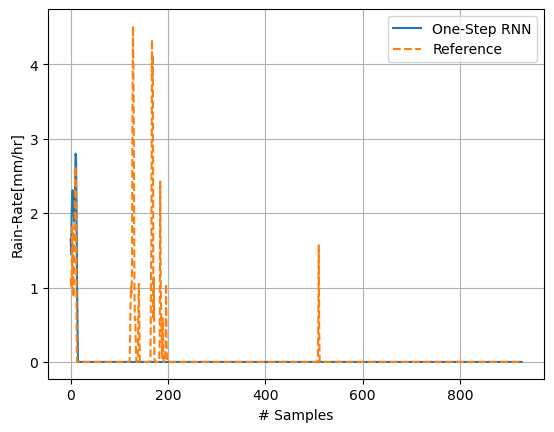

In [58]:
rain_hat_array = np.concatenate(rain_hat_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)

plt.plot(np.maximum(rain_hat_array[0, :], 0), label="One-Step RNN")
plt.plot(rain_ref_array[0, :],"--", label="Reference")
plt.grid()
plt.legend()
plt.ylabel("Rain-Rate[mm/hr]")
plt.xlabel("# Samples")
plt.show()